# Lossy Compression with Convolutional Autoencoders

## 1. Import Dependencies

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split, Dataset

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install optuna # For Hyperparameter Tuning
import optuna
import optuna.visualization as vis

## 2. Data Loading & Feature Engineering

Uploaded all 3 image folders to my drive and combined them into one dataset.
The shape of the final dataset is (1196, 101250)

In [5]:
from google.colab import drive

drive.mount('/content/drive')
sub1 = np.load('/content/drive/MyDrive/Autoencoder CW/data/subset_1.npy')
sub2 = np.load('/content/drive/MyDrive/Autoencoder CW/data/subset_2.npy')
sub3 = np.load('/content/drive/MyDrive/Autoencoder CW/data/subset_3.npy')

inputs = np.vstack((sub1, sub2, sub3))
inputs.shape

Mounted at /content/drive


(1196, 101250)

Displaying an image:

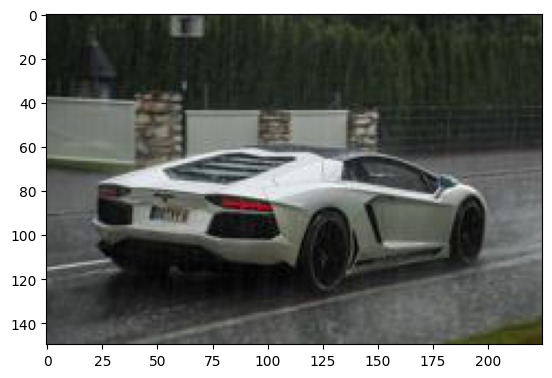

In [6]:
def display(img):
    plt.imshow(np.reshape(img, (150, 225, 3)))
    plt.show()
display(inputs[0])

Data preprocessing:
- Reshaping the dataset into (batch_size, h, w, c) representation
- Normalization of dataset
- Permutation into (batch_size, c, h, w) representation for PyTorch model compatibility

In [7]:
dataset = inputs.reshape(1196, 150, 225, 3)
dataset = torch.tensor(dataset, dtype=torch.float32) / 255
dataset = dataset.permute(0, 3, 1, 2)

### Data Loading for PyTorch Model

Defined a batch size. The final model had a batch size of 16. Hyperparameter tuning by Optuna was performed with range of batch sizes (16, 32, 64, 128) as we will see later.

In [8]:
BATCH_SIZE = 16

Data Split:
- 80% Training
- 10% Testing
- 10% Validation

In [10]:
size = len(dataset)
tr_size = int(0.8 * size)
val_size = int(0.1 * size)
tt_size = size - tr_size - val_size

train_X, val_X, test_X = random_split(dataset, [tr_size, val_size, tt_size])

batch_size = BATCH_SIZE

trainloader = DataLoader(train_X, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_X, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_X, batch_size=batch_size, shuffle=False)

print(f"Training samples: {tr_size}, Validation samples: {val_size}, Test samples: {tt_size}")

Training samples: 956, Validation samples: 119, Test samples: 121


In [11]:
dataiter = iter(trainloader)
images = next(dataiter)
print(torch.min(images), torch.max(images))
print('Image Shape:' ,images.shape)

tensor(0.) tensor(1.)
Image Shape: torch.Size([16, 3, 150, 225])


### Data Augmentation:
As mentioned in the report, I experimented with Augmentations before deciding against them because of poor performance.
Below are the augmentations I experimented with:

strong augmentation:
- +/= 10 degree random rotation
- 50% chance of horizontal flip
- small briightness/contrast change

mild augmentation:
- reduced rotation range
- reduced flip probability (30%)
- reduced brightness/contrast variation

Augmentations were not applied to test and validation sets

In [ ]:
strong = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

mild = transforms.Compose([
    transforms.RandomRotation((-3, 3)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(
        brightness=0.05,
        contrast=0.05,
        saturation=0,
        hue=0
    ),
    transforms.ToTensor()
])

# No augmentation for validation/test sets
test_transform = transforms.ToTensor()

class Augment(Dataset):

    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = (img * 255).astype(np.uint8)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img

tr_aug = AugmentedDataset(dataset[:tr_size], transform = mild)
val_aug = AugmentedDataset(dataset[tr_size : tr_size+val_size], transform = test_transform)
tt_aug = AugmentedDataset(dataset[tr_size + val_size:], transform = test_transform)

batch_size = BATCH_SIZE

trainloader = DataLoader(tr_aug, batch_size = batch_size, shuffle=True)
valloader = DataLoader(val_aug, batch_size = batch_size, shuffle=False)
testloader = DataLoader(tt_aug, batch_size = batch_size, shuffle=False)

print(f"Training samples: {tr_size}, Validation samples: {val_size}, Test samples: {tt_size}")

## 3. Model Development


### Building the AutoEncoder Network

### Building the model

Defined the latent vector size below. The selected model had a latent vector size of 2250. This was chosen after experimenting with 5 different latent dimensions. (2025, 2250, 3165, 4050, 8440)

Compression Ratios I experimented with:
Original dimensions: 3 × 150 × 225 = 101,250 pixels
- 12:1 ratio: ~8,440
- 25:1 ratio: ~4,050
- 32:1 ratio: ~3,165
- 45:1 ratio: ~2,250
- 50:1 ratio: ~2,025

In [12]:
latent_dims = [2025, 2250, 3165, 4050, 8440]
FINAL_LATENT_DIM = 2250

In [13]:
class AutoEncoder_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.latent_dim = FINAL_LATENT_DIM

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 9 * 14, self.latent_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.decoder = nn.Sequential(

            nn.Linear(self.latent_dim, 128 * 9 * 14),
            nn.BatchNorm1d(128 * 9 * 14),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (128, 9, 14)),

            nn.Upsample(size=(12, 28), mode='bilinear', align_corners=False),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(size=(24, 56), mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(size=(75, 113), mode='bilinear', align_corners=False),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(size=(150, 225), mode='bilinear', align_corners=False),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### Training

Final model initialisation was as below. These are the optimal hyperparameters as determined by Optuna.
- Criterion - MSE
- Optimiser - Adam
- Learning Rate - 1e-3
- Weight decay - 1e-5

In [43]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder_CNN().to(device)

criterion = nn.MSELoss().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2.1e-6)

summary(model, input_size=(3, 150, 225))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 225]             896
         MaxPool2d-2          [-1, 32, 75, 112]               0
       BatchNorm2d-3          [-1, 32, 75, 112]              64
         LeakyReLU-4          [-1, 32, 75, 112]               0
            Conv2d-5          [-1, 64, 75, 112]          18,496
         MaxPool2d-6           [-1, 64, 37, 56]               0
       BatchNorm2d-7           [-1, 64, 37, 56]             128
         LeakyReLU-8           [-1, 64, 37, 56]               0
            Conv2d-9          [-1, 128, 37, 56]          73,856
        MaxPool2d-10          [-1, 128, 18, 28]               0
      BatchNorm2d-11          [-1, 128, 18, 28]             256
        LeakyReLU-12          [-1, 128, 18, 28]               0
           Conv2d-13          [-1, 128, 18, 28]         147,584
        MaxPool2d-14           [-1, 128

#### LR Scheduler
The final training featured a learning rate scheduler, initialised below: The LR scheduler would decrease the learning rate by a factor of 0.5 after 5 epochs without improvement.

In [44]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5 ,
    verbose=True,
    min_lr=1e-6
)

#### Early Stopping
The final training also featured Early stopping. The results in the report were obtained by setting patience to 20.

In [45]:
class EarlyStopping:

    def __init__(self, patience=10, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):

        if val_loss < self.best_loss - self.min_delta:  # checking if current val loss is better than best loss
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = self._get_model_copy(model)
        else:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter}/{self.patience}')

            if self.counter >= self.patience:
                self.early_stop = True
                print(f'Early stopping triggered. Best val_loss: {self.best_loss:.6f}')

    def _get_model_copy(self, model):
        return {key: val.cpu().clone() for key, val in model.state_dict().items()}

In [46]:
early_stopping = EarlyStopping(patience=20, min_delta=0.0001)

#### Training Loop

In the final training, 100 epochs were run, early stopping and LR scheduler were both engaged.



In [47]:
# Training Loop
num_epochs = 100
outputs = []


loss_history = []
val_loss_history = []

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    batch_count = 0

    for images in trainloader:
        images = images.to('cuda')
        recon = model(images)
        loss = criterion(recon, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_count += 1

    avg_epoch_loss = running_loss / batch_count
    epoch_loss = running_loss / len(trainloader)
    loss_history.append(epoch_loss)

    # Validation Loop
    model.eval()
    running_val_loss = 0.0
    batch_count = 0

    with torch.no_grad():
        for images in valloader:
            images = images.to('cuda')
            recon = model(images)
            val_loss = criterion(recon, images)

            running_val_loss += val_loss.item()
            batch_count += 1

    avg_val_loss = running_val_loss / batch_count
    val_loss_history.append(avg_val_loss)

    # LR Scheduler Engaged
    scheduler.step(avg_epoch_loss)

    # Log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f},Val Loss: {avg_val_loss:.4f}, LR: {current_lr:.2e}")
    outputs.append((epoch, images, recon))

    # Early Stopping Engaged
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
      print(f"Early stopping triggered at epoch {epoch+1}")
      model.load_state_dict(early_stopping.best_model)
      break


Epoch [1/100], Train Loss: 0.0542,Val Loss: 0.0343, LR: 1.00e-05
Epoch [2/100], Train Loss: 0.0321,Val Loss: 0.0257, LR: 1.00e-05
Epoch [3/100], Train Loss: 0.0252,Val Loss: 0.0214, LR: 1.00e-05
Epoch [4/100], Train Loss: 0.0214,Val Loss: 0.0187, LR: 1.00e-05
Epoch [5/100], Train Loss: 0.0196,Val Loss: 0.0175, LR: 1.00e-05
Epoch [6/100], Train Loss: 0.0173,Val Loss: 0.0169, LR: 1.00e-05
EarlyStopping counter: 1/20
Epoch [7/100], Train Loss: 0.0164,Val Loss: 0.0153, LR: 1.00e-05
Epoch [8/100], Train Loss: 0.0160,Val Loss: 0.0149, LR: 1.00e-05
Epoch [9/100], Train Loss: 0.0151,Val Loss: 0.0148, LR: 1.00e-05
EarlyStopping counter: 1/20
Epoch [10/100], Train Loss: 0.0140,Val Loss: 0.0143, LR: 1.00e-05
EarlyStopping counter: 2/20
Epoch [11/100], Train Loss: 0.0138,Val Loss: 0.0139, LR: 1.00e-05
Epoch [12/100], Train Loss: 0.0137,Val Loss: 0.0135, LR: 1.00e-05
Epoch [13/100], Train Loss: 0.0132,Val Loss: 0.0141, LR: 1.00e-05
EarlyStopping counter: 1/20
Epoch [14/100], Train Loss: 0.0124,Val 

#### Hyperparameter Tuning with Optuna

In [19]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):

    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])

    trainloader = DataLoader(train_X, batch_size=batch_size, shuffle=True, num_workers=4)
    valloader = DataLoader(val_X, batch_size=batch_size, shuffle=False, num_workers=4)

    model = AutoEncoder_CNN().to(device)
    criterion = nn.MSELoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters(), weight_decay=weight_decay, lr=learning_rate)

    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images in trainloader:
            images = images.to(device)
            recon = model(images)
            loss = criterion(recon, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images in valloader:
                images = images.to(device)
                recon = model(images)
                val_loss += criterion(recon, images).item()

        avg_val_loss = val_loss / len(valloader)

        # Pruning
        trial.report(avg_val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return avg_val_loss


Tuning process: Creating Optuna study with TPE sampler.
20 trials due to computational limitations


In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20)

best_params = study.best_params
print(f"Best Batch Size: {best_params['batch_size']}")
print(f"Best Learning Rate: {best_params['learning_rate']}")
print(f"Best Optimizer: {best_params['optimizer']}")
print(f"Best Weight Decay: {best_params['weight_decay']}")


[I 2025-03-19 00:03:51,763] A new study created in memory with name: no-name-22157aef-fe65-411d-9059-074913f2e943
<ipython-input-54-3f6070066e4c>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)  # Log scale for better exploration
<ipython-input-54-3f6070066e4c>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than

Best Batch Size: 16
Best Learning Rate: 0.00010403962398810673
Best Optimizer: Adam
Best Weight Decay: 2.1352871135505094e-06


Visualisation: Graph of the hyperparameter importances.

In [19]:
vis.plot_param_importances(study).show()


In [ ]:
vis.plot_optimization_history(study).show()


## Model Evaluations & Figure Creations

### Training vs Validation Chart

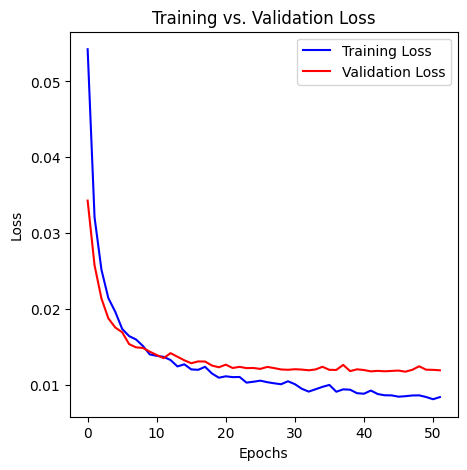

In [48]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(5, 5))
    plt.plot(train_losses, label="Training Loss", linestyle='-', color='b')
    plt.plot(val_losses, label="Validation Loss", linestyle='-', color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs. Validation Loss")
    plt.legend()
    plt.show()

plot_loss(loss_history, val_loss_history)

### Visualisation of Reconstructions

In [49]:
def visualize_reconstructions(model, dataloader, device='cuda', num_images=3):
    model.eval()

    images = next(iter(dataloader))
    images = images[:num_images]
    images_device = images.to(device)

    with torch.no_grad():
        reconstructions = model(images_device)

    images = images.cpu()
    reconstructions = reconstructions.cpu()

    differences = torch.abs(images - reconstructions)

    fig, axes = plt.subplots(3, num_images, figsize=(num_images * 4, 7))

    def normalize_for_display(img_tensor):
        img_np = img_tensor.permute(1, 2, 0).numpy()
        return np.clip(img_np, 0, 1)

    row_titles = ['Original', 'Reconstruction', 'Difference']

    for i in range(num_images):

        # original image
        img_original = normalize_for_display(images[i])
        axes[0, i].imshow(img_original)
        axes[0, i].set_title(f"{row_titles[0]} {i+1}")
        axes[0, i].axis('off')

        # reconstructed image
        img_recon = normalize_for_display(reconstructions[i])
        axes[1, i].imshow(img_recon)
        axes[1, i].set_title(f"{row_titles[1]} {i+1}")
        axes[1, i].axis('off')

        img_diff = normalize_for_display(differences[i])
        # heatmap for difference visualization
        diff_map = axes[2, i].imshow(img_diff, cmap='hot')
        axes[2, i].set_title(f"{row_titles[2]} {i+1}")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.suptitle("Comparison of Original Images vs Reconstructions", fontsize=12, y=0.98)
    plt.subplots_adjust(top=0.9, right=0.9)

    return fig


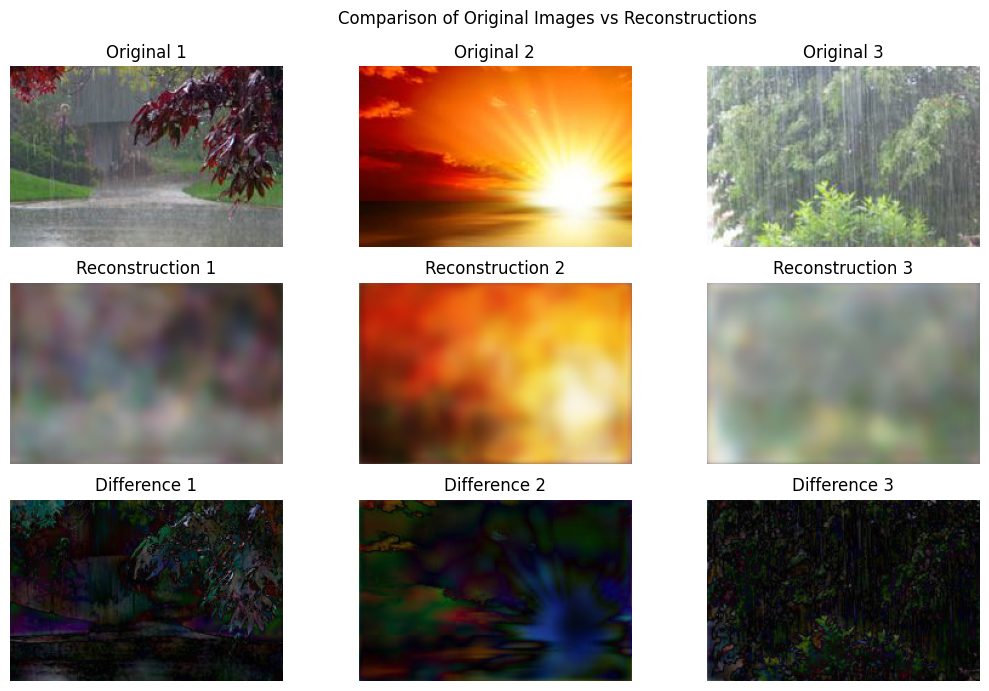

In [50]:
fig = visualize_reconstructions(model, testloader)

### Evaluation Metrics Pipeline

The 3 metrics I have spoken about in my report are:
- Mean Squared Error (MSE)
- Peak Signal to Noise Ratio (PSNR)
- Structural Similarity Index (SSIM)

In [51]:
from skimage.metrics import structural_similarity as ssim

# Define test function
def eval_pipeline(model, dataloader):

    model.to('cuda')
    model.eval()
    mse_list, psnr_list, ssim_list = [], [], []

    with torch.no_grad():
        for images in dataloader:
            images = images.to('cuda')
            outputs = model(images)

            images_np = images.cpu().numpy()
            images_np = np.squeeze(images_np)
            outputs_np = outputs.cpu().numpy()
            outputs_np = np.squeeze(outputs_np)

            # MSE
            mse = F.mse_loss(outputs, images).item()
            mse_list.append(mse)

            # PSNR
            psnr = 10 * np.log10(1 / mse) if mse > 0 else float('inf')
            psnr_list.append(psnr)

            # SSIM
            for i in range(len(images_np)):
                img1 = np.transpose(images_np[i], (1, 2, 0))
                img2 = np.transpose(outputs_np[i], (1, 2, 0))
                ssim_val = ssim(img1, img2, data_range=1.0, channel_axis=2)
                ssim_list.append(ssim_val)

    avg_mse = np.mean(mse_list)
    avg_psnr = np.mean(psnr_list)
    avg_ssim = np.mean(ssim_list)

    print(f"Test MSE: {avg_mse:.4f}")
    print(f"Test PSNR: {avg_psnr:.2f} dB")
    print(f"Test SSIM: {avg_ssim:.4f}")

    return mse_list, psnr_list, ssim_list


Test MSE: 0.0132
Test PSNR: 18.84 dB
Test SSIM: 0.5050


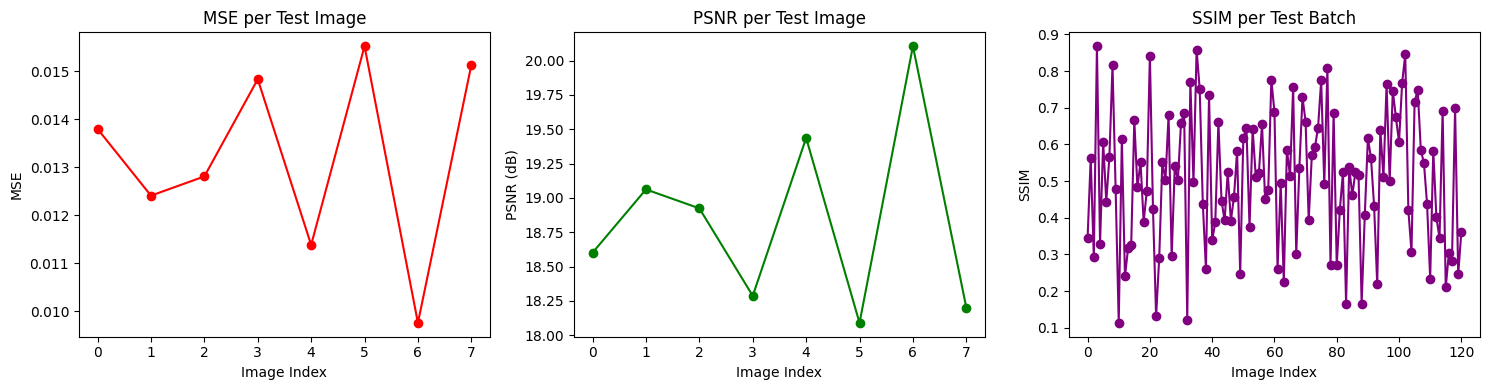

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

mse_list, psnr_list, ssim_list = eval_pipeline(model, testloader)

axes[0].plot(mse_list, 'r', marker='o')
axes[0].set_title("MSE per Test Image")
axes[0].set_xlabel("Image Index")
axes[0].set_ylabel("MSE")

axes[1].plot(psnr_list, 'g', marker='o')
axes[1].set_title("PSNR per Test Image")
axes[1].set_xlabel("Image Index")
axes[1].set_ylabel("PSNR (dB)")

axes[2].plot(ssim_list, 'purple', marker='o')
axes[2].set_title("SSIM per Test Batch")
axes[2].set_xlabel("Image Index")
axes[2].set_ylabel("SSIM")

plt.tight_layout()
plt.show()


### Model Comparison Graphs
How the base models across diff latent spaces performed

In [25]:
model2025 = {'latent-space': 2025, 'ratio':'50:1', 'batch-size': 32, 'final-loss':0.0118, 'test-mse': 0.0131, 'test-ssim':0.5190, 'psnr':18.84}
model3165 = {'latent-space': 3165, 'ratio':'25:1', 'batch-size': 32, 'final-loss':0.0112, 'test-mse': 0.0149, 'test-ssim':0.5081, 'psnr':18.27}
model2250 = {'latent-space': 2250, 'ratio':'45:1', 'batch-size': 32, 'final-loss':0.0120, 'test-mse': 0.0141, 'test-ssim':0.5197, 'psnr':18.51}
model4050 = {'latent-space': 4050, 'ratio':'32:1', 'batch-size': 32, 'final-loss':0.0122, 'test-mse': 0.0142, 'test-ssim':0.5113, 'psnr':18.49}
model8440 = {'latent-space': 8440, 'ratio':'12:1', 'batch-size': 32, 'final-loss':0.0116, 'test-mse': 0.0137, 'test-ssim':0.5206, 'psnr':18.63}

models = [model2025, model2250, model3165, model4050, model8440]

labels = ['model2025', 'model2250', 'model3165', 'model4050', 'model8440']
latent_sizes = []
ssim_scores = []
psnrs = []
mse_values = []

for model in models:
  latent_sizes.append(model['latent-space'])
  ssim_scores.append(model['test-ssim'])
  psnrs.append(model['psnr'])
  mse_values.append(model['final-loss'])


#### Latent Space vs SSIM -
How perceptual image quality trends with compression ratio (Lower Latent Space => More Compression)

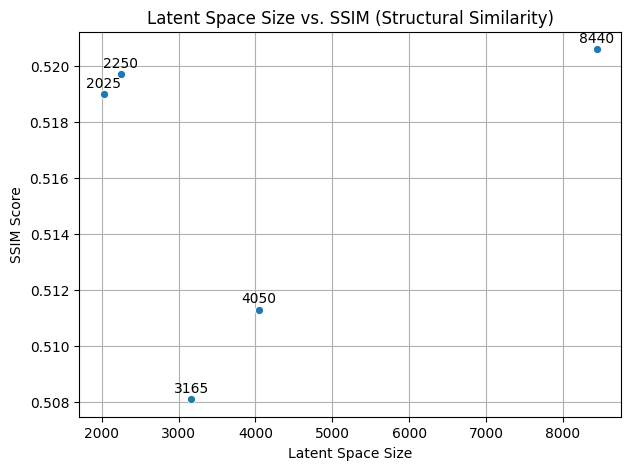

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
sns.lineplot(x=latent_sizes, y=ssim_scores, marker='o', linestyle='')

for i, txt in enumerate(latent_sizes):
    plt.annotate(txt, (latent_sizes[i], ssim_scores[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Latent Space Size")
plt.ylabel("SSIM Score")
plt.title("Latent Space Size vs. SSIM (Structural Similarity)")
plt.grid(True)
plt.show()

#### Latent Space vs MSE
What loss every latent space model achieved

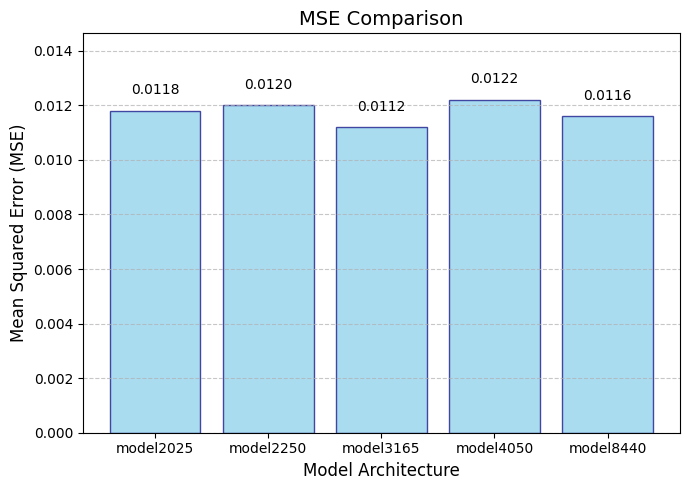

In [27]:
plt.figure(figsize=(7, 5))
bars = plt.bar(labels, mse_values, color='skyblue', edgecolor='navy', alpha=0.7)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
             f'{mse_values[i]:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.title('MSE Comparison', fontsize=14)
plt.xlabel('Model Architecture', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(mse_values) * 1.2)
plt.tight_layout()
plt.savefig('model_mse_comparison.png', dpi=300)
plt.show()

#### SSIM vs MSE
Compression Ratio vs Reconstruction Quality tradeoff

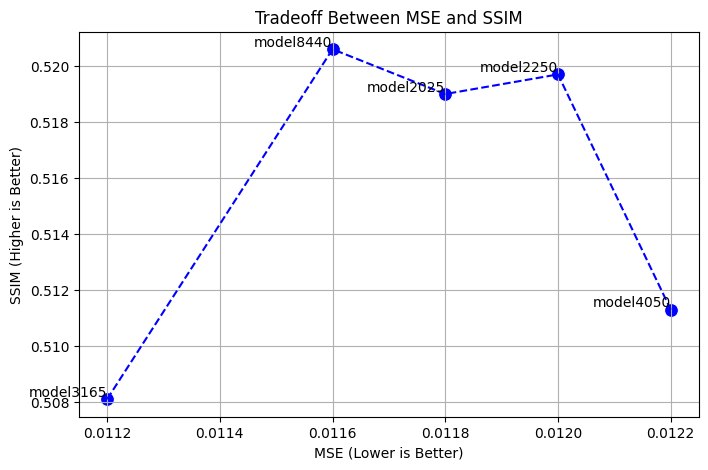

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

ssim_values = ssim_scores

plt.figure(figsize=(8, 5))
sns.scatterplot(x=mse_values, y=ssim_values, marker='o', color='b', s=100)
sns.lineplot(x=mse_values, y=ssim_values, linestyle='--', color='b')

for i, model in enumerate(labels):
    plt.text(mse_values[i], ssim_values[i], model, fontsize=10, ha='right', va='bottom')

plt.xlabel("MSE (Lower is Better)")
plt.ylabel("SSIM (Higher is Better)")
plt.title("Tradeoff Between MSE and SSIM")
plt.grid(True)
plt.show()
